# Knapsack Resolution Analysis

This notebook analyzes the results of solving 0-1 knapsack problems using various solution methods. The analysis evaluates both complete (exact) and incomplete (heuristic) algorithms across different instance sizes and problem characteristics.

In [78]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Graphics configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [79]:
#### Reading Data ####
data_path = os.path.join('..', 'results', 'results.csv')
if not os.path.exists(data_path):
    # Try alternative path if run from root
    data_path = 'results/results.csv'

data = pd.read_csv(data_path)
print(f"Data successfully loaded: {len(data)} rows")

# Ensure numeric types
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
data['Time(ms)'] = pd.to_numeric(data['Time(ms)'], errors='coerce')
data['n'] = pd.to_numeric(data['n'], errors='coerce')
data['Optimal'] = data['Optimal'].astype(str).str.lower().isin(['true', '1'])

data.head()

Data successfully loaded: 222 rows


,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%)
0,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Complete_MIP_ORTools,20995,28.578758,2,True,-1,-1.0
1,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Complete_MIP_PuLP,20995,67.155123,-1,True,-1,-1.0
2,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Simple,20995,0.000000,0,False,-1,-1.0
3,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Random_k3,20760,3.242493,0,False,-1,-1.0
4,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Probabilistic_alpha0.9,18220,2.991199,0,False,-1,-1.0


In [80]:
#### Calculate Optimality Gaps (Robust Edition) ####
threshold = 0.01

# 1. Best value found across ALL methods for each instance
best_overall = data.groupby(['Instance', 'n', 'Capacity'])['Value'].max().reset_index()
best_overall.columns = ['Instance', 'n', 'Capacity', 'Best_Overall']

# 2. Merge with original data
data = pd.merge(data, best_overall, on=['Instance', 'n', 'Capacity'], how='left')

# 3. Calculate gap relative to the best known solution
# Value_Ref will be max(Best_Overall, OptimalKnown if > 0)
data['Value_Ref'] = data['Best_Overall']
if 'OptimalKnown' in data.columns:
    mask = data['OptimalKnown'] > 0
    data.loc[mask, 'Value_Ref'] = data.loc[mask, ['Best_Overall', 'OptimalKnown']].max(axis=1)

data['Gap(%)'] = 100 * (data['Value_Ref'] - data['Value']) / data['Value_Ref']

#### 4. Update Optimal flag ####
# For heuristic methods: Optimal = True if gap is within threshold
# For complete methods: Optimal = True ONLY if solve was deemed optimal AND gap is small
data['Optimal_Original'] = data['Optimal']

def refine_optimal(row):
    gap_is_small = row['Gap(%)'] <= threshold * 100
    if 'Complete' in row['Method']:
        return row['Optimal_Original'] and gap_is_small
    return gap_is_small

data['Optimal'] = data.apply(refine_optimal, axis=1)

data.head()

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%),Value_GT
0,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Complete_MIP_ORTools,20995,28.578758,2,True,-1,0.000000,20995
1,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Complete_MIP_PuLP,20995,67.155123,-1,True,-1,0.000000,20995
2,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Simple,20995,0.000000,0,True,-1,0.000000,20995
3,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Random_k3,20760,3.242493,0,False,-1,1.119314,20995
4,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_Greedy_Probabilistic_alpha0.9,18220,2.991199,0,False,-1,13.217433,20995


In [81]:
#### Adding TimeOut Column ####
timeout_ms = 300_000
data['TimeOut'] = data['Time(ms)'] >= timeout_ms-100

# Mark Timeout if complete method didn't prove optimality
complete_methods = [m for m in data['Method'].unique() if 'Complete' in m]
data.loc[(data['Method'].isin(complete_methods)) & (data['Optimal'] == False), 'TimeOut'] = True

print(f"Timeouts detected: {data['TimeOut'].sum()}")

Timeouts detected: 22


## Visualizations

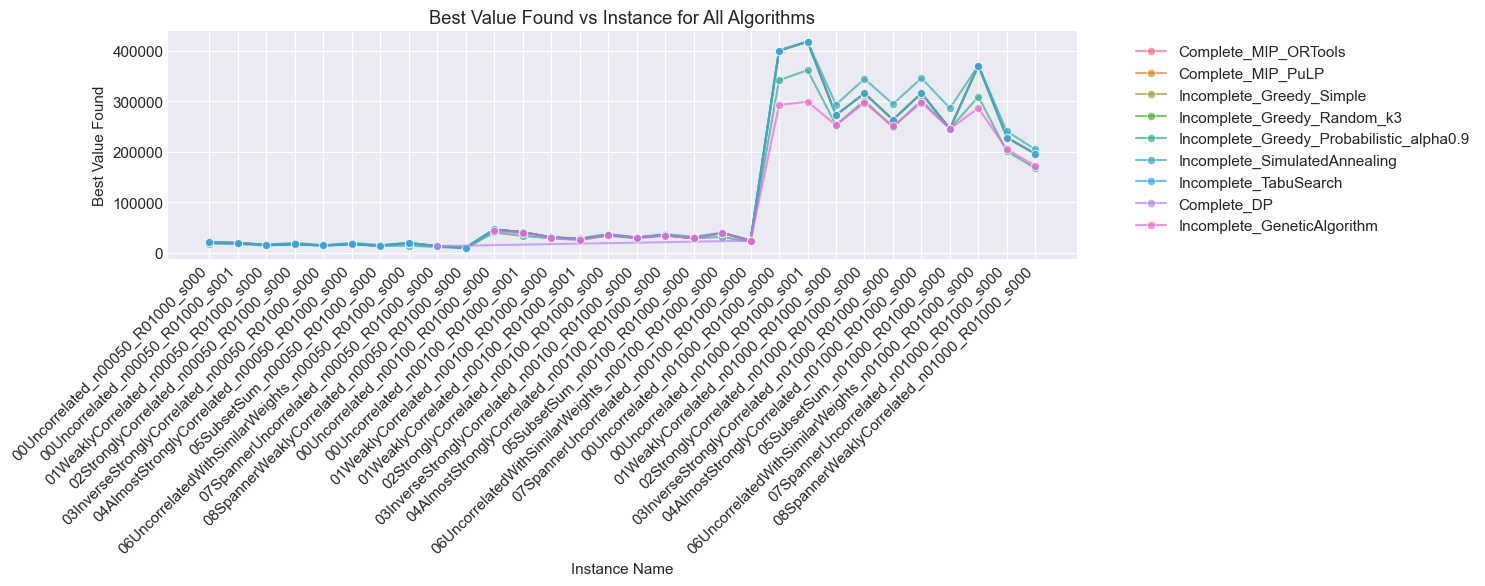

In [82]:
#### Plot best value found per instances ####
plt.figure(figsize=(15, 6))
sns.lineplot(data=data.sort_values('n'), x='Instance', y='Value', hue='Method', marker='o', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Instance Name')
plt.ylabel('Best Value Found')
plt.title('Best Value Found vs Instance for All Algorithms')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

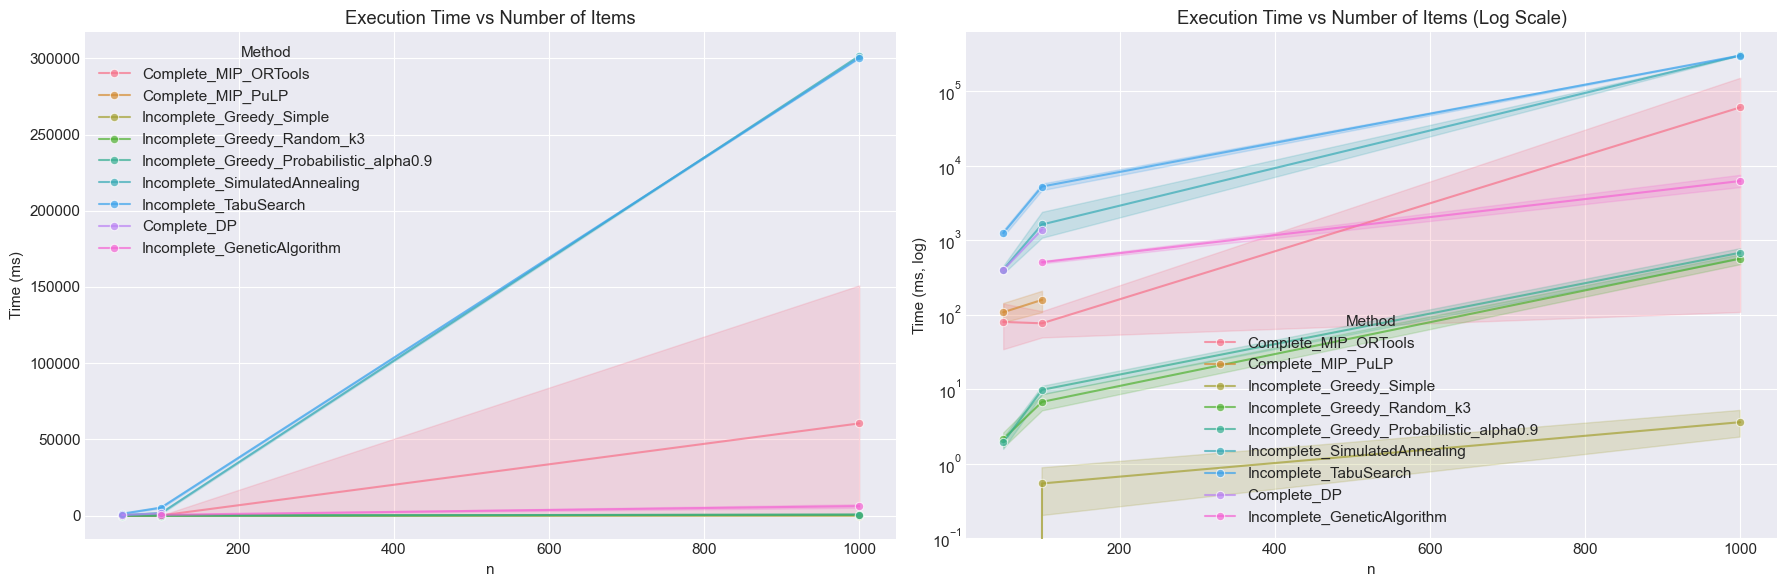

In [83]:
#### Plot time vs n ####
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(data=data, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7, ax=ax1)
ax1.set_title('Execution Time vs Number of Items')
ax1.set_ylabel('Time (ms)')

sns.lineplot(data=data, x='n', y='Time(ms)', hue='Method', marker='o', alpha=0.7, ax=ax2)
ax2.set_yscale('log')
ax2.set_title('Execution Time vs Number of Items (Log Scale)')
ax2.set_ylabel('Time (ms, log)')

plt.tight_layout()
plt.show()

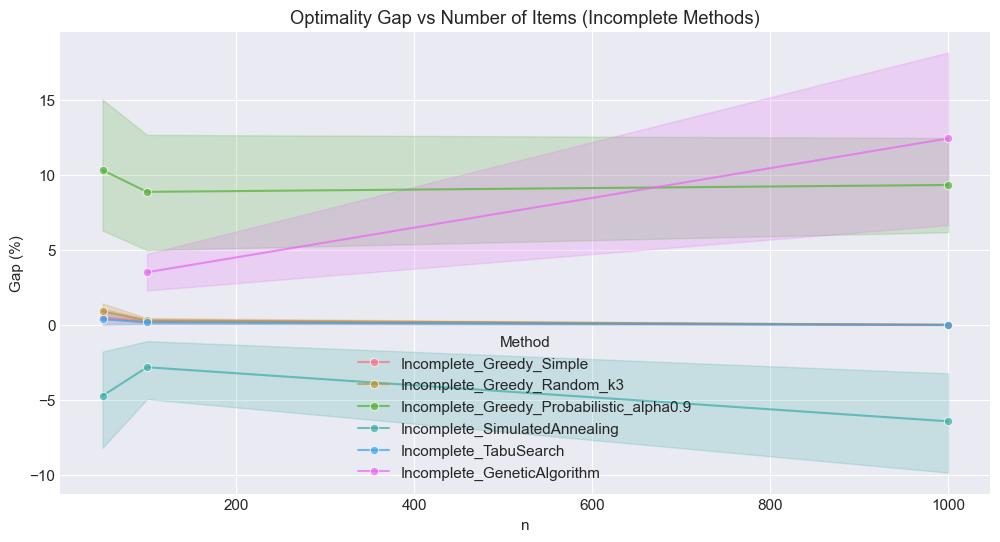

In [84]:
#### Plot Optimality Gap vs n ####
plt.figure(figsize=(12, 6))
incomplete_only = data[~data['Method'].isin(complete_methods)]
if not incomplete_only.empty:
    sns.lineplot(data=incomplete_only, x='n', y='Gap(%)', hue='Method', marker='o', alpha=0.7)
    plt.title('Optimality Gap vs Number of Items (Incomplete Methods)')
    plt.ylabel('Gap (%)')
    plt.show()
else:
    print("No incomplete methods data to plot gaps.")

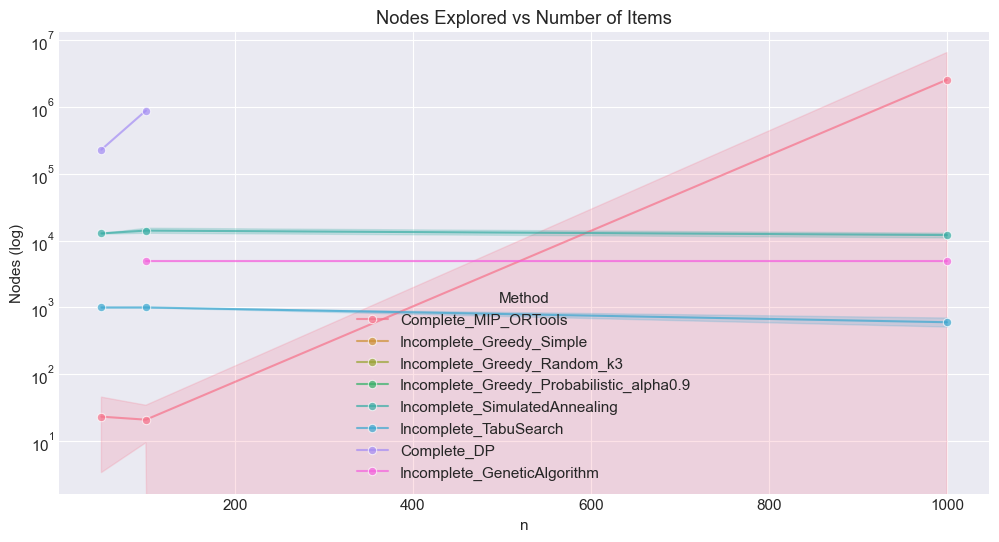

In [85]:
#### Plot Nodes Explored vs n ####
if 'Nodes' in data.columns and (data['Nodes'] > 0).any():
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data[data['Nodes'] >= 0], x='n', y='Nodes', hue='Method', marker='o', alpha=0.7)
    plt.yscale('log')
    plt.title('Nodes Explored vs Number of Items')
    plt.ylabel('Nodes (log)')
    plt.show()

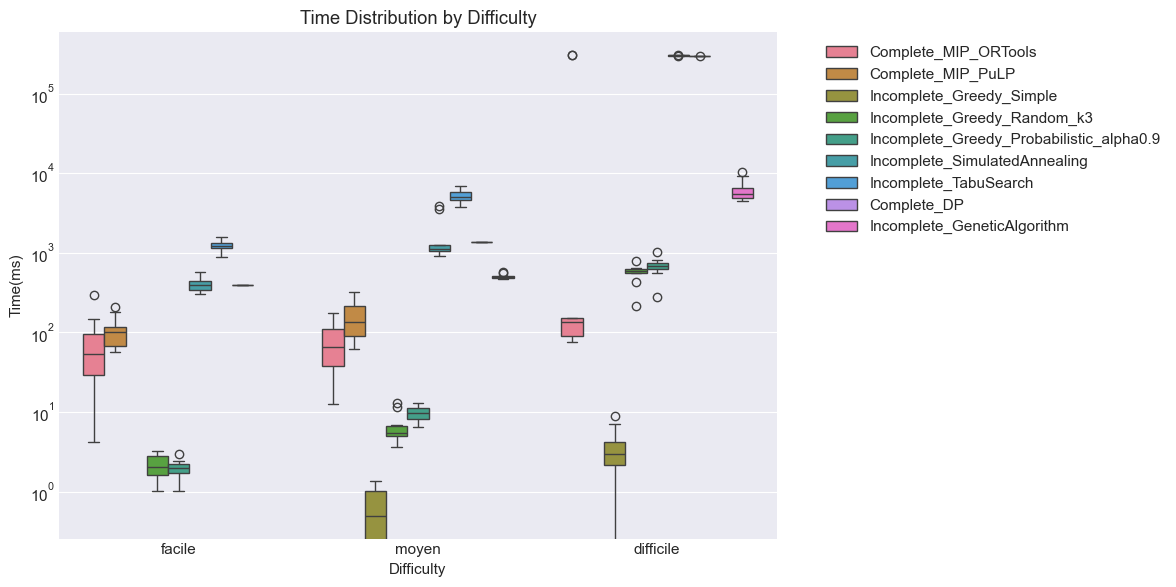

In [86]:
#### Execution Time Distribution by Difficulty ####
if 'Difficulty' in data.columns:
    plt.figure(figsize=(12, 6))
    # Order difficulties
    diff_order = ['facile', 'moyen', 'difficile']
    existing_diffs = [d for d in diff_order if d in data['Difficulty'].unique()]
    
    sns.boxplot(data=data, x='Difficulty', y='Time(ms)', hue='Method', order=existing_diffs)
    plt.yscale('log')
    plt.title('Time Distribution by Difficulty')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [87]:
#### Summary Table ####
summary = data.groupby('Method').agg({
    'Value': 'mean',
    'Time(ms)': 'mean',
    'Gap(%)': 'mean',
    'Optimal': 'mean',
    'TimeOut': 'sum'
}).round(4)

summary.columns = ['Mean Value', 'Mean Time (ms)', 'Mean Gap (%)', 'Success Rate', 'Timeouts']
summary = summary.sort_values('Mean Time (ms)')
summary

,Mean Value,Mean Time (ms),Mean Gap (%),Success Rate,Timeouts
Method,,,,,
Incomplete_Greedy_Simple,117812.0667,1.3812,0.2521,0.9333,0
Complete_MIP_PuLP,25267.7500,132.6675,-0.0005,1.0000,0
Incomplete_Greedy_Random_k3,117774.5333,191.7045,0.4093,0.8667,0
Incomplete_Greedy_Probabilistic_alpha0.9,106320.6333,229.8343,9.5136,0.0667,0
Complete_DP,18850.0000,890.8392,0.0000,1.0000,0
Incomplete_GeneticAlgorithm,146534.0500,3358.9978,7.9773,0.1000,0
Complete_MIP_ORTools,117876.6667,20209.8534,0.0000,1.0000,2
Incomplete_SimulatedAnnealing,124152.9667,101213.4579,-4.6564,1.0000,10
Incomplete_TabuSearch,117826.6000,102258.3231,0.1860,0.9333,10


In [88]:
# Regarder les instances problématiques
df[df['Method'] == 'Incomplete_SimulatedAnnealing'].sort_values('Gap(%)').head()

,Instance,Difficulty,Class,n,Capacity,TotalWeight,TotalProfit,Method,Value,Time(ms),Nodes,Optimal,OptimalKnown,Gap(%)
5,00Uncorrelated_n00050_R01000_s000,facile,Unknown,50,14778,29853,28763,Incomplete_SimulatedAnnealing,20995,371.607304,12815,False,-1,-1.0
12,00Uncorrelated_n00050_R01000_s001,facile,Unknown,50,13598,27468,23823,Incomplete_SimulatedAnnealing,19836,573.934317,13258,False,-1,-1.0
19,01WeaklyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,29802,Incomplete_SimulatedAnnealing,16509,432.951689,12652,False,-1,-1.0
26,02StronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,14239,28763,33763,Incomplete_SimulatedAnnealing,19876,338.402033,12545,False,-1,-1.0
33,03InverseStronglyCorrelated_n00050_R01000_s000,facile,Unknown,50,16714,33763,28763,Incomplete_SimulatedAnnealing,15225,351.413727,12673,False,-1,-1.0
